# Readme

Cross validation for the 'rnn 9 - data a.' model, using normalized data.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from rnn_module import AmmoniaRNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data processing

## Data embeddings

In [5]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_rnn_3.csv")

In [6]:
data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

In [7]:
data_embeddings['pmid_copy'] = data_embeddings['pmid']

data_embeddings['pmid'] = data_embeddings.apply(
    lambda row: f"{row['pmid']}_{row['dt']}" if row['interpolation'] == "yes" else str(row['pmid']),
    axis=1
)

In [8]:
data_embeddings.shape

(98277, 23)

In [9]:
data_embeddings.head (2)

,e.cum,delta_e.cum,e.cum_shift,dt,dt_origin,inst,pmid,country,meas.tech,ct,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,interpolation,pmid_copy
0,3.574,3.574,0.000,2.0,4.0,104,182_2.0,DK,micro met,2.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes,182
1,7.148,3.574,3.574,2.0,4.0,104,182_2.0,DK,micro met,4.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes,182


## Test samples

In [10]:
with open("../00_data_preparation/processed_data/list_train_pmids.json", "r") as f:
    list_train_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_eval_pmids.json", "r") as f:
    list_eval_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_test_pmids.json", "r") as f:
    list_test_pmids = json.load(f)

In [11]:
len (list_train_pmids)

15

# Normalisation function

In [12]:
columns = ['ct', 'dt', 'air.temp', 'wind.2m', 'rain.rate', 'tan.app', 'app.rate', 'man.dm', 'man.ph', 't.incorp']

In [13]:
data_normalisation_test = data_embeddings.copy()

In [14]:
def compute_normalization_stats(df, columns):
    means = df[columns].mean()
    stds = df[columns].std()
    
    return means, stds


In [15]:
means, stds = compute_normalization_stats (data_normalisation_test, columns)

In [16]:
def normalize_dataframe(df, means, stds):
    df_normalized = df.copy()
    for col in means.index:
        if col in df.columns:
            df_normalized[col] = (df[col] - means[col]) / stds[col]
    return df_normalized


In [17]:
data_normalised = normalize_dataframe (data_normalisation_test, means, stds)

In [18]:
means_2, stds_2 = compute_normalization_stats (data_normalised, columns)

In [19]:
stds_2

ct           1.0
dt           1.0
air.temp     1.0
wind.2m      1.0
rain.rate    1.0
tan.app      1.0
app.rate     1.0
man.dm       1.0
man.ph       1.0
t.incorp     1.0
dtype: float64

# Cross validation

In [20]:
response = ["delta_e.cum"]
bidirectional = [True]
mlp = [True]
with_embeddings = [True]
num_params = [None]

hyper_grid = pd.DataFrame(
    itertools.product(response, bidirectional, mlp, with_embeddings, num_params), 
    columns=["response", "bidirectional", "mlp", "with_embeddings", "num_params"]
)

hyper_grid.insert(0, "model", range(1, len(hyper_grid) + 1))

hyper_grid.style.hide(axis="index")

model,response,bidirectional,mlp,with_embeddings,num_params
1,delta_e.cum,True,True,True,None


In [21]:
p = 15

In [22]:
folder_path = "results/05_4_model_comparison_with_data_augmentation_with_normalisation/df_res"

df_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):  
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)  
        df_list.append(df)

df_all_predictions = pd.concat(df_list, ignore_index=True)

In [23]:
df_all_predictions.shape

(9976, 14)

In [24]:
df_all_predictions.head (2)

,sample,model,n_parameters,pmid,e.cum,delta_e.cum,ct,dt,air.temp,wind.2m,rain.rate,prediction_ecum,prediction_delta_ecum,running_time
0,11,1,570474,190,10.586,10.586,-1.381014,-0.131241,-0.029828,0.243002,0.204317,6.217999,6.217999,265.476786
1,11,1,570474,190,15.530,4.944,-1.035154,2.028289,-0.623437,-0.087098,-0.243614,8.065222,1.847223,265.476786


In [25]:
hyper_grid.head (4).style.hide(axis="index")

model,response,bidirectional,mlp,with_embeddings,num_params
1,delta_e.cum,True,True,True,None


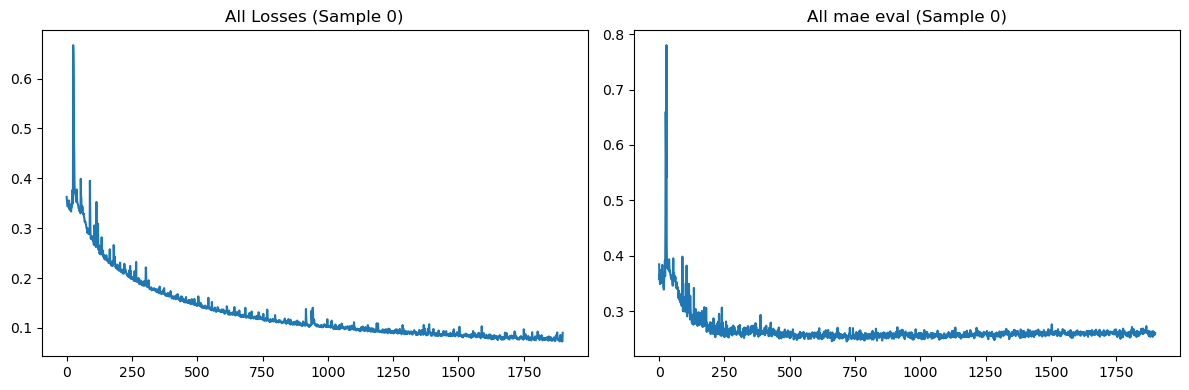

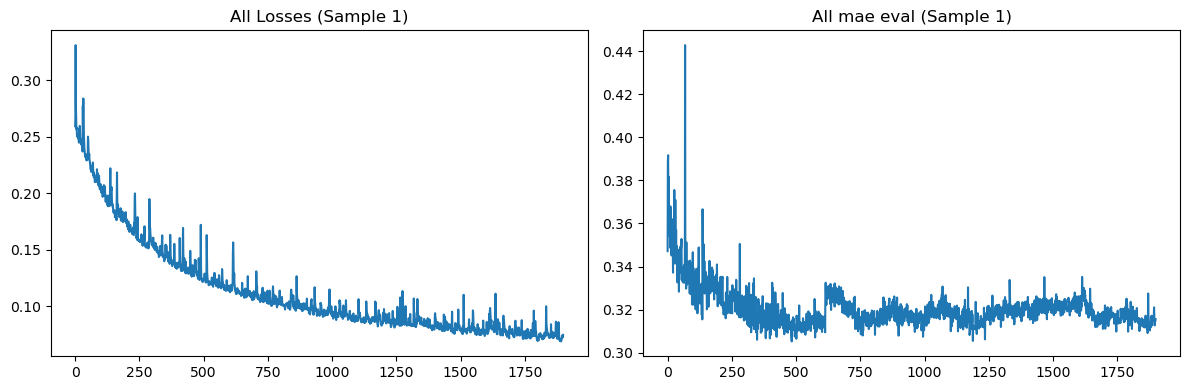

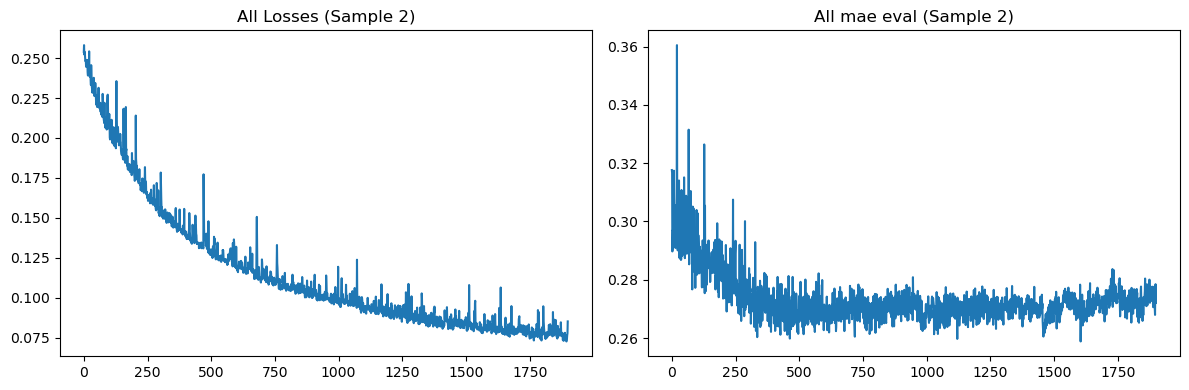

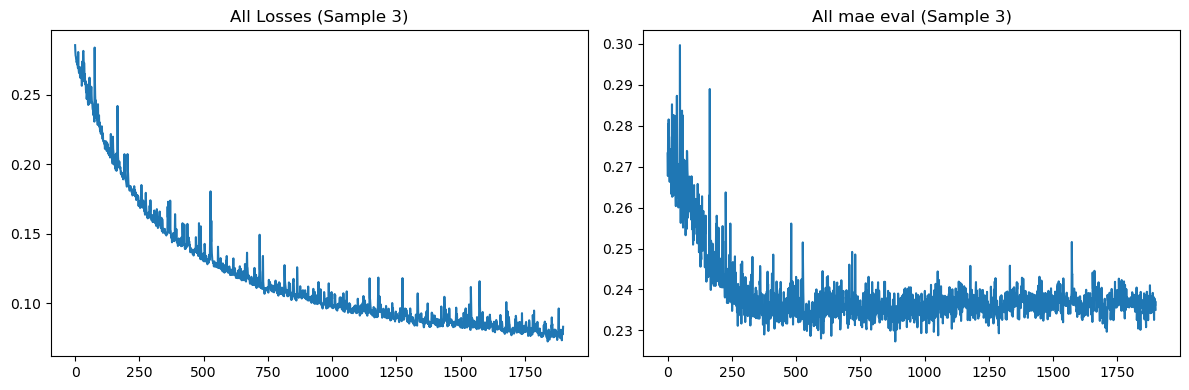

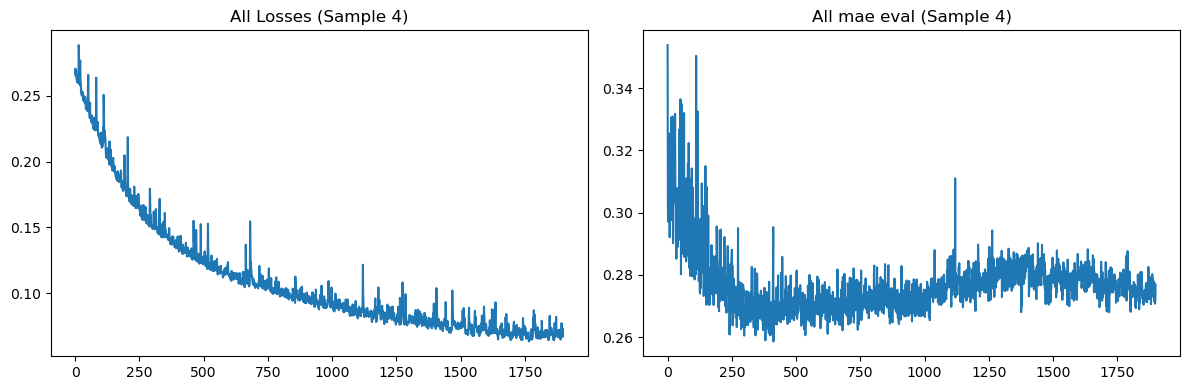

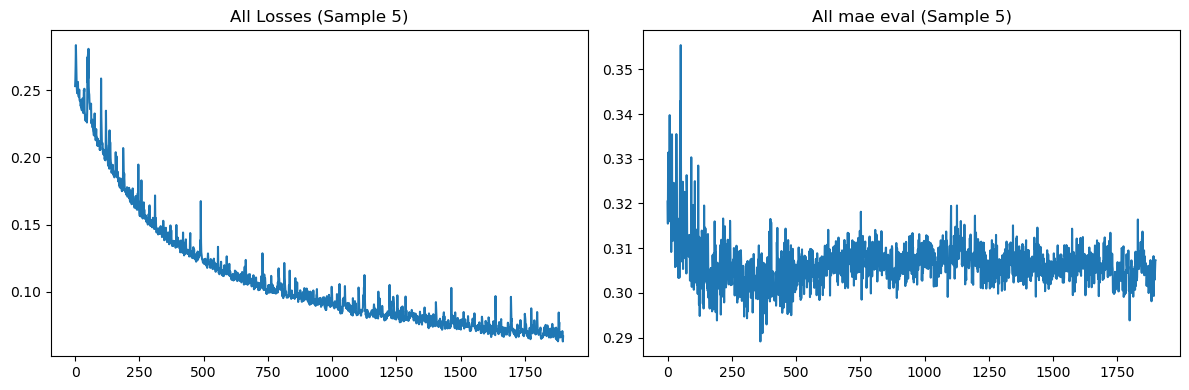

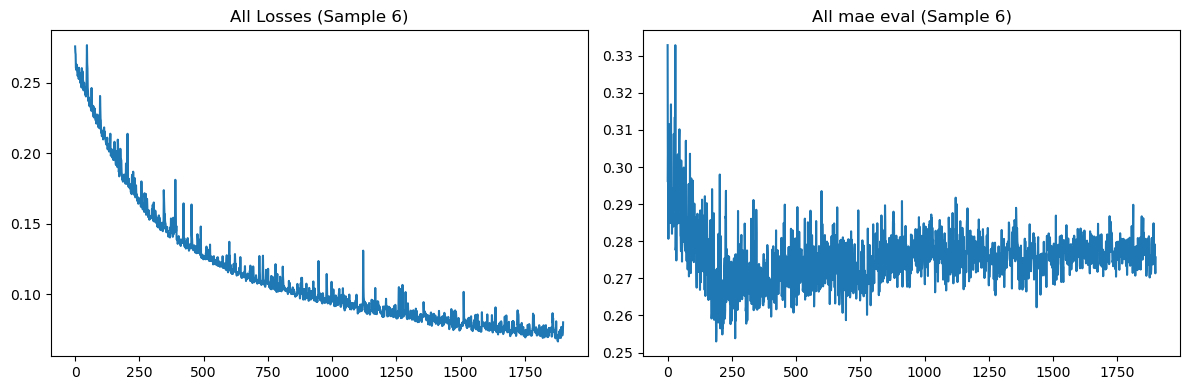

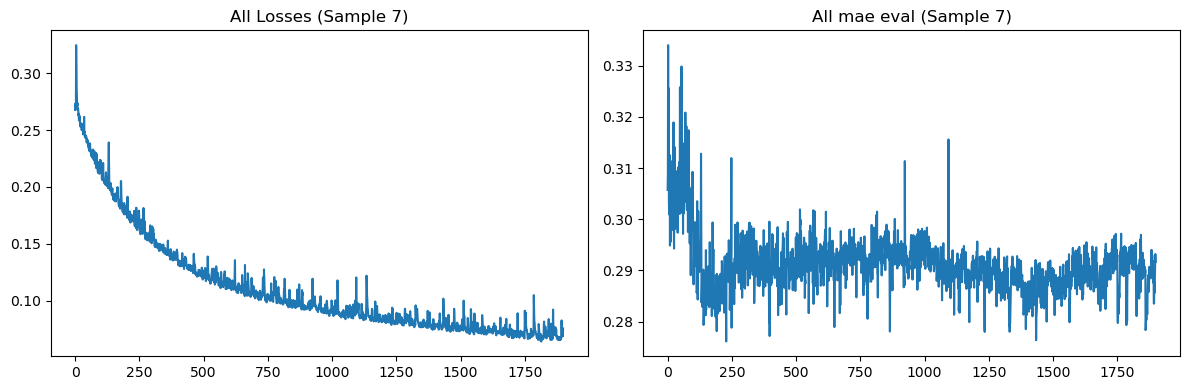

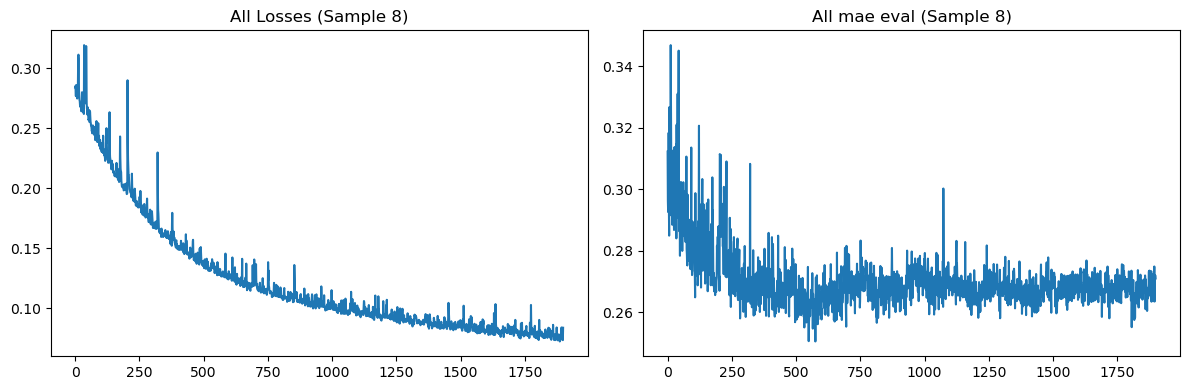

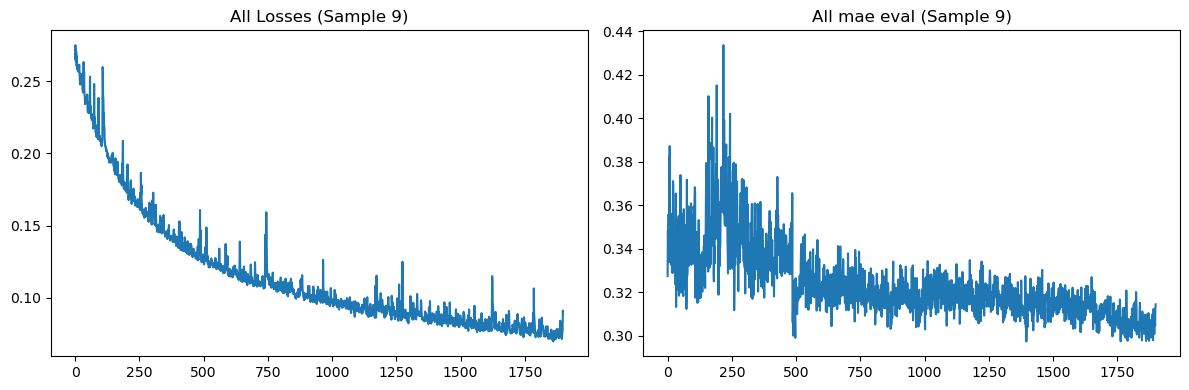

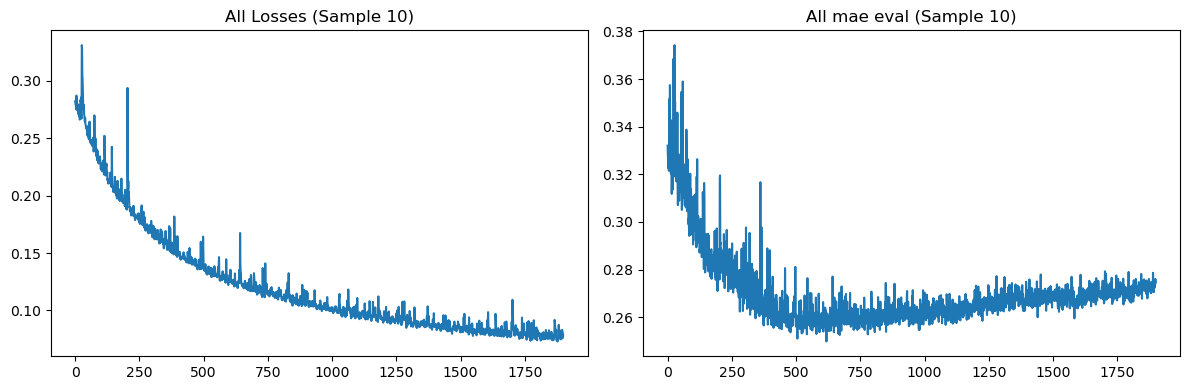

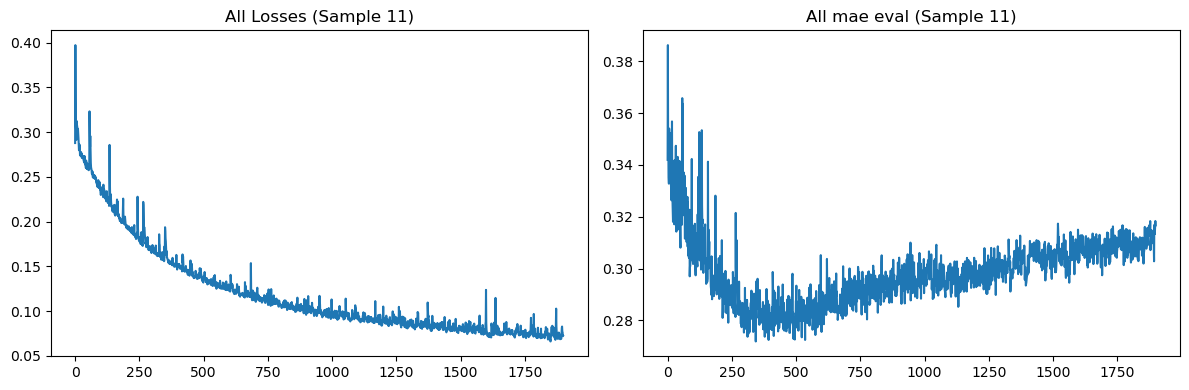

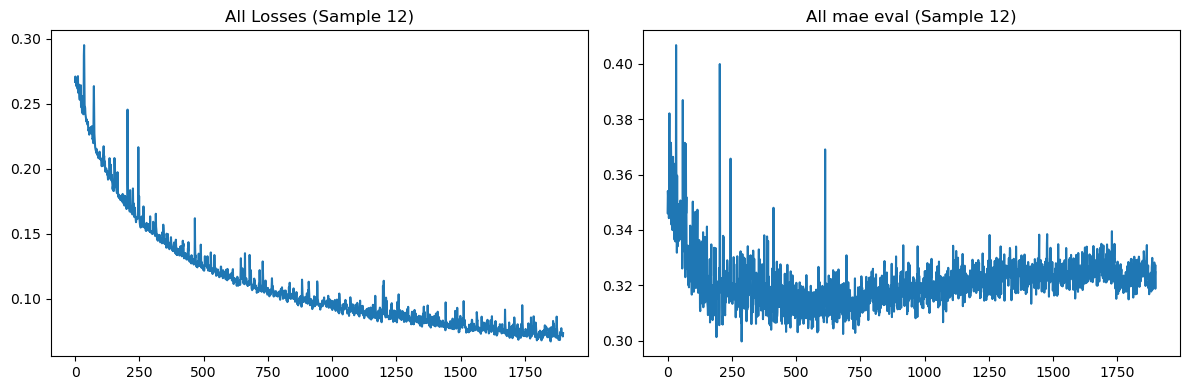

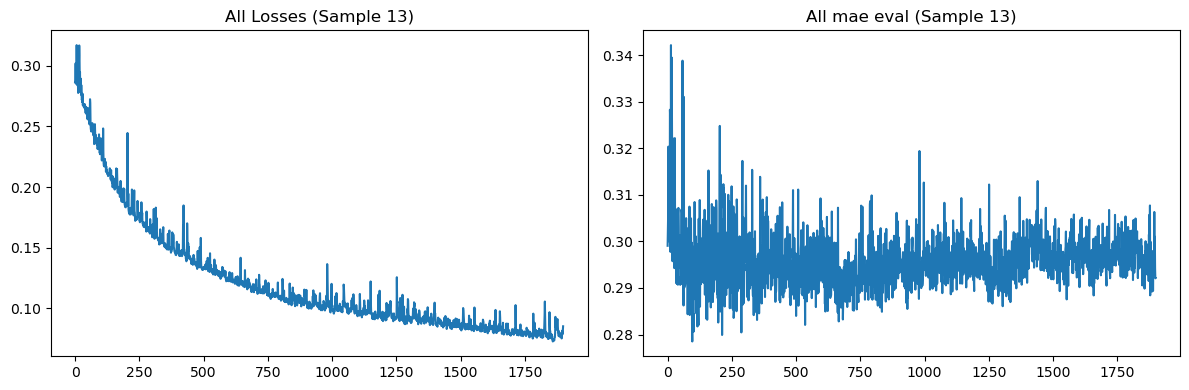

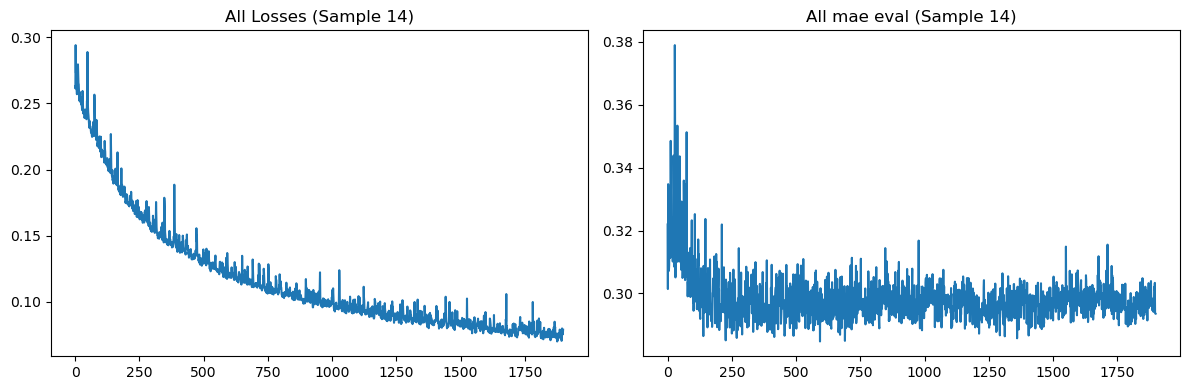

In [26]:
model_index = 1

for sample in range (p):

    with open(f'results/05_4_model_comparison_with_data_augmentation_with_normalisation/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_mae_eval = pickle.load(f)

    with open(f'results/05_4_model_comparison_with_data_augmentation_with_normalisation/all_losses/all_losses_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_losses = pickle.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

    axes[0].plot(all_losses[100:])
    axes[0].set_title(f'All Losses (Sample {sample})')

    axes[1].plot(all_mae_eval[100:])
    axes[1].set_title(f'All mae eval (Sample {sample})')

    plt.tight_layout()

    plt.show()

# End